In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

# types for type hinting
from dataload import DenseReweights as dr


C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\pydantic\_internal\_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\pydantic\_internal\_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [2]:
from dataload import seploader as sepl

loader = sepl.SEPLoader()

In [3]:
# loader.load('../cme_and_electron/new_data/cme_josias_10MeV.csv', output_dir='../cme_and_electron/data')

In [4]:
loader.load('../cme_and_electron/new_data/cme_josias_10MeV.csv', num_folds=3, output_dir='../cme_and_electron/folds')

In [4]:
# train_x, train_y, val_x, val_y, test_x, test_y = loader.load_from_dir('../cme_and_electron/data')

In [ ]:
train_x, train_y, val_x, val_y, test_x, test_y = loader.load_from_dir('../cme_and_electron/fold2')

In [4]:
# Read the CSV file
file_path = '../cme_and_electron/cme_josias_10MeV.csv'
df = pd.read_csv(file_path)

In [11]:
def split_data(df):
    """
    Splits the data into training, validation, and test sets according to the specified rules.
    
    :param:
    - df: DataFrame containing the data. Assumes 'log_peak_intensity' is the target column.
    
    :return:
    - train_x, train_y, val_x, val_y, test_x, test_y: Numpy arrays containing the split data
    """
    # Sort the DataFrame by 'log_peak_intensity' in descending order
    df_sorted = df.sort_values(by='log_peak_intensity', ascending=False).reset_index(drop=True)

    # Initialize empty lists to store indices for training, validation, and test sets
    train_indices = []
    val_indices = []
    test_indices = []

    # Group every 3 rows for test set selection
    for i in range(0, len(df_sorted), 3):
        group = list(range(i, min(i + 3, len(df_sorted))))
        test_idx = np.random.choice(group, 1)[0]
        train_indices.extend([idx for idx in group if idx != test_idx])
        test_indices.append(test_idx)

    # Group every 4 rows for validation set selection from the training set
    for i in range(0, len(train_indices), 4):
        group = train_indices[i: i + 4]
        if len(group) == 0:
            continue
        val_idx = np.random.choice(group, 1)[0]
        val_indices.append(val_idx)
        train_indices = [idx for idx in train_indices if idx != val_idx]

    # Extract the feature and target sets based on selected indices
    features = df_sorted.drop(columns=['log_peak_intensity']).to_numpy()
    target = df_sorted['log_peak_intensity'].to_numpy()

    train_x = features[train_indices]
    train_y = target[train_indices]
    val_x = features[val_indices]
    val_y = target[val_indices]
    test_x = features[test_indices]
    test_y = target[test_indices]

    return train_x, train_y, val_x, val_y, test_x, test_y


# Test the function
train_x, train_y, val_x, val_y, test_x, test_y = split_data(df)

# Show the shape of the resulting arrays to ensure correctness
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape), (test_x.shape, test_y.shape)


(((1225, 19), (1225,)), ((307, 19), (307,)), ((766, 19), (766,)))

In [12]:
def plot_sorted_distributions(y_train, y_val, y_test, title='Sorted Distributions'):
    """
    Plots the sorted target variable distributions for the training, validation, and test sets.
    
    :param:
    - y_train: Numpy array containing the training set target variable
    - y_val: Numpy array containing the validation set target variable
    - y_test: Numpy array containing the test set target variable
    - title: Title for the plot
    """
    plt.figure(figsize=(12, 6))

    # Sort and plot the target variable for each set
    plt.plot(np.sort(y_train), label='Train', marker='o')
    plt.plot(np.sort(y_val), label='Validation', marker='x')
    plt.plot(np.sort(y_test), label='Test', marker='s')

    plt.xlabel('Index')
    plt.ylabel('log_peak_intensity')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

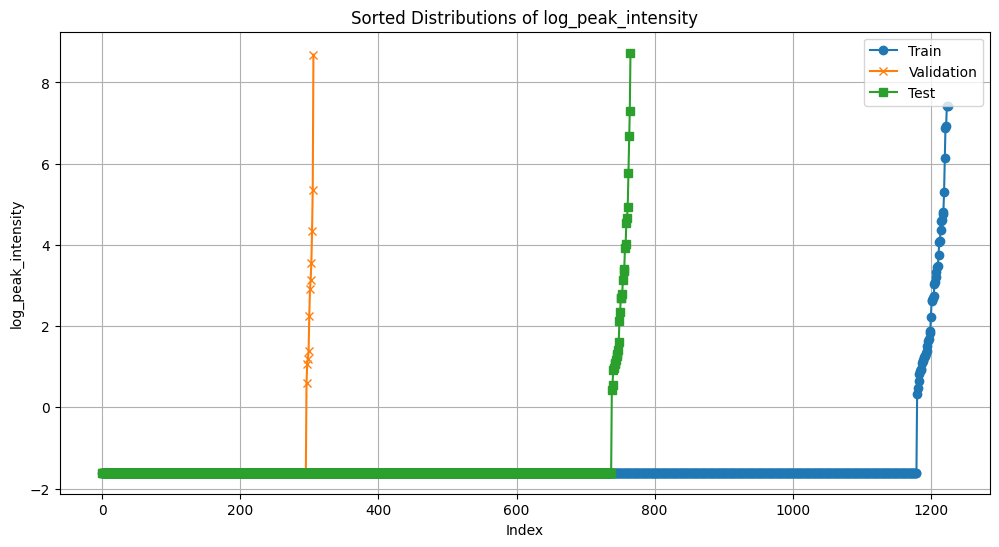

In [13]:
plot_sorted_distributions(train_y, val_y, test_y, title='Sorted Distributions of log_peak_intensity')

In [6]:
concatenated_x, concatenated_y = concatenate_datasets(train_x, train_y, val_x, val_y, test_x, test_y)

In [7]:
# get validation sample weights based on dense weights
sample_weights = dr.DenseReweights(concatenated_x, concatenated_y, alpha=.9, debug=True).reweights

X_train:  [[0.10263593 0.12737226 0.14174757 0.11748927 0.         0.11829945
  0.38961039 0.4        0.25555556 0.27638191 0.27586207 0.47752809
  0.25197016 0.22222222 0.         0.836019   0.40458495 0.
  0.        ]
 [0.05305486 0.07591241 0.13268608 0.1123927  0.         0.06395564
  0.15584416 0.34444444 0.30555556 0.12562814 0.20689655 0.41573034
  0.25932542 0.31666667 0.         0.90422584 0.32124345 0.
  0.        ]
 [0.20593914 0.25218978 0.27346278 0.22103004 0.         0.24251386
  0.24675325 0.18055556 0.38611111 0.16080402 0.34482759 0.23595506
  0.25764422 0.34166667 0.         0.93730677 0.82838906 0.
  0.        ]
 [0.0621716  0.12408759 0.16213592 0.11856223 0.         0.11275416
  0.41558442 0.32222222 0.31944444 0.3919598  0.17241379 0.33707865
  0.26037617 0.36388889 0.         0.90245624 0.40027608 0.
  0.        ]
 [0.16885977 0.22153285 0.21294498 0.17730687 0.         0.21146026
  0.5974026  0.24444444 0.31666667 0.53266332 0.09195402 0.33146067
  0.25081433 0

AttributeError: 'numpy.ndarray' object has no attribute 'evaluate'

X_train:  [[0.10263593 0.12737226 0.14174757 0.11748927 0.         0.11829945
  0.38961039 0.4        0.25555556 0.27638191 0.27586207 0.47752809
  0.25197016 0.22222222 0.         0.836019   0.40458495 0.
  0.        ]
 [0.05305486 0.07591241 0.13268608 0.1123927  0.         0.06395564
  0.15584416 0.34444444 0.30555556 0.12562814 0.20689655 0.41573034
  0.25932542 0.31666667 0.         0.90422584 0.32124345 0.
  0.        ]
 [0.20593914 0.25218978 0.27346278 0.22103004 0.         0.24251386
  0.24675325 0.18055556 0.38611111 0.16080402 0.34482759 0.23595506
  0.25764422 0.34166667 0.         0.93730677 0.82838906 0.
  0.        ]
 [0.0621716  0.12408759 0.16213592 0.11856223 0.         0.11275416
  0.41558442 0.32222222 0.31944444 0.3919598  0.17241379 0.33707865
  0.26037617 0.36388889 0.         0.90245624 0.40027608 0.
  0.        ]
 [0.16885977 0.22153285 0.21294498 0.17730687 0.         0.21146026
  0.5974026  0.24444444 0.31666667 0.53266332 0.09195402 0.33146067
  0.25081433 0

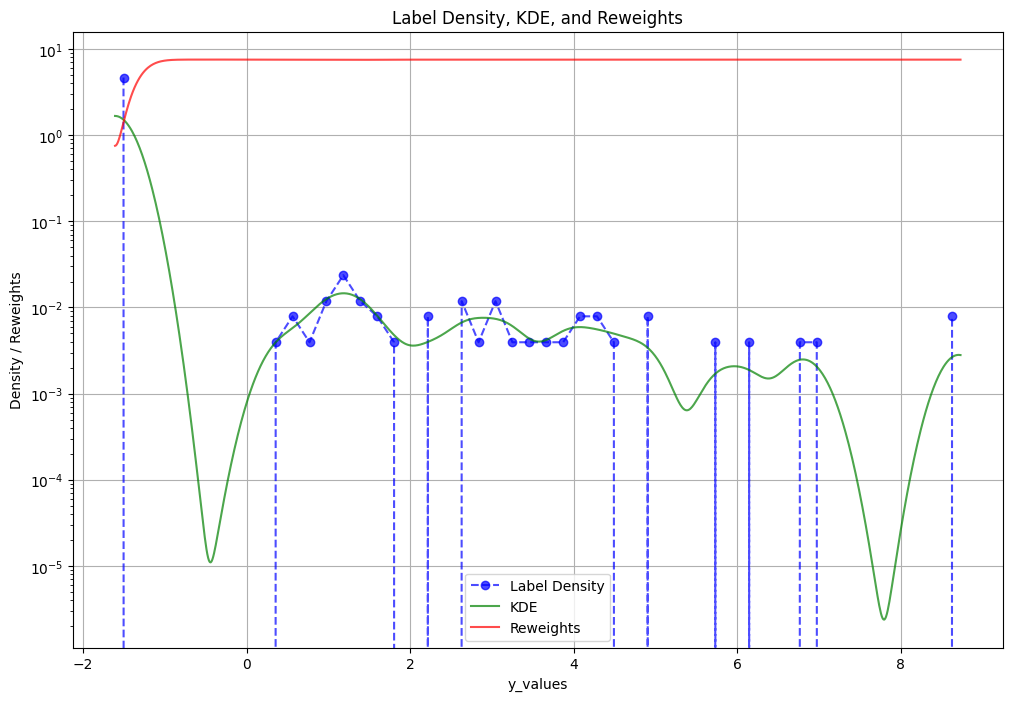

X_train:  [[0.14424515 0.09051095 0.15275081 0.         0.         0.09463956
  0.79220779 0.15       0.41666667 0.85929648 0.26436782 0.25280899
  0.1850373  0.41944444 0.5        0.94569452 0.34883066 0.
  0.        ]
 [0.05694052 0.15072993 0.10550162 0.10863734 0.         0.21848429
  0.64935065 0.76944444 0.67777778 0.22110553 0.31034483 0.34831461
  0.25743407 0.68055556 0.25       0.71091145 0.43302973 0.
  0.        ]
 [0.09071929 0.1459854  0.20744337 0.16791845 0.         0.1349353
  0.05194805 0.9        0.93611111 0.24120603 0.22988506 0.73033708
  0.2678365  0.99444444 0.         0.84678991 0.42760542 0.
  0.        ]
 [0.04843758 0.1149635  0.02071197 0.         0.         0.18669131
  0.61038961 0.27777778 0.225      0.22110553 0.2183908  0.57303371
  0.23557844 0.20277778 0.25       0.94879435 0.38760013 0.
  0.        ]
 [0.16178243 0.1350365  0.24595469 0.31223176 0.         0.13123845
  0.24675325 0.74722222 0.23888889 0.25125628 0.35632184 0.42134831
  0.3033519  0.

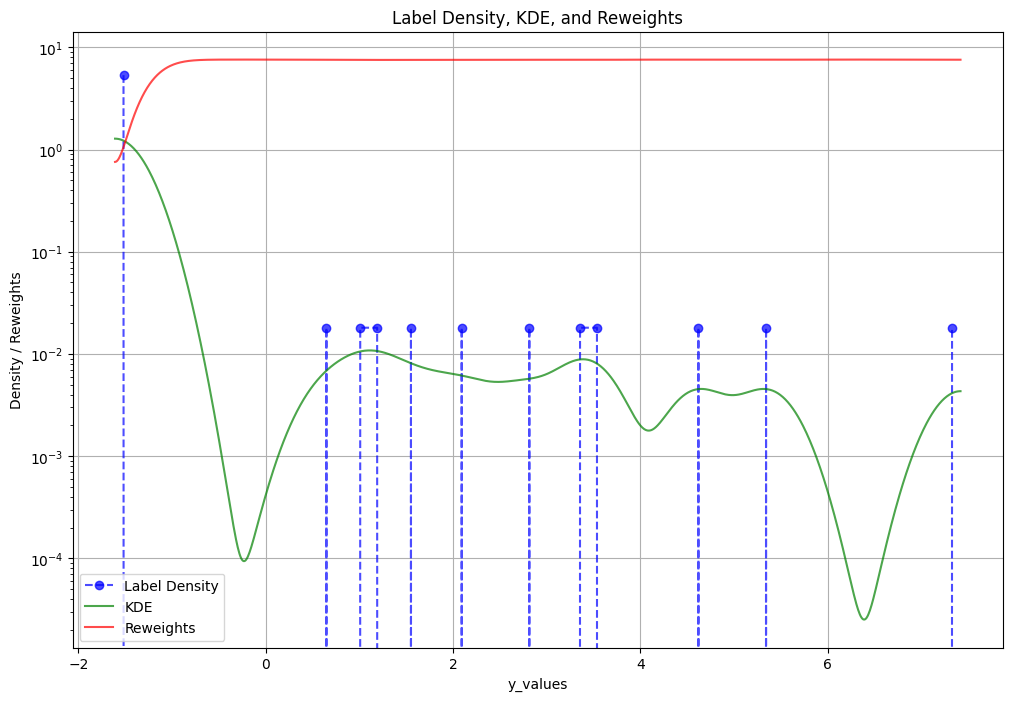

In [5]:
# get validation sample weights based on dense weights
sample_weights = dr.DenseReweights(train_x, train_y, alpha=.9, debug=True).reweights
val_sample_weights = dr.DenseReweights(val_x, val_y, alpha=.9, debug=True).reweights

In [6]:
def shuffle_sets(train_x, train_y, val_x, val_y, test_x, test_y):
    """
    Shuffle the data within each of the training, validation, and test sets.
    
    :param:
    - train_x, train_y: Numpy arrays containing the training features and labels
    - val_x, val_y: Numpy arrays containing the validation features and labels
    - test_x, test_y: Numpy arrays containing the test features and labels
    
    :return:
    - Shuffled versions of train_x, train_y, val_x, val_y, test_x, test_y
    """
    train_x, train_y = shuffle(train_x, train_y)
    val_x, val_y = shuffle(val_x, val_y)
    test_x, test_y = shuffle(test_x, test_y)

    return train_x, train_y, val_x, val_y, test_x, test_y


# Shuffle the datasets
shuffled_train_x, shuffled_train_y, shuffled_val_x, shuffled_val_y, shuffled_test_x, shuffled_test_y = shuffle_sets(
    train_x, train_y, val_x, val_y, test_x, test_y)


In [7]:
from models import modeling
from sklearn.manifold import TSNE

In [8]:
mb = modeling.ModelBuilder()

# create my feature extractor
feature_extractor = mb.create_model_pds(input_dim=19, feat_dim=9, hiddens=[18])

In [9]:
# print model summary
feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19)]              0         
                                                                 
 dense (Dense)               (None, 18)                360       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 18)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                 171       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 9)                 0         
                                                                 
 normalize_layer (NormalizeL  (None, 9)                0         
 ayer)                                                           
                                                             

In [10]:
# plot model
mb.plot_model(feature_extractor)

In [11]:
def plot_tsne(model, X, y):
    """
    Applies t-SNE to the features extracted by the given model and plots them in 2D.
    The color of the points is determined by their label values.
    
    Parameters:
    - model: Trained feature extractor model
    - X: Input data
    - y: Target labels
    
    Returns:
    - A 2D t-SNE plot
    """
    # Extract features using the trained model
    features = model.predict(X)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(features)

    # Create a scatter plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y, cmap='viridis', alpha=0.6)

    # Add a color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Label Value')

    plt.title('2D t-SNE Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    plt.show()

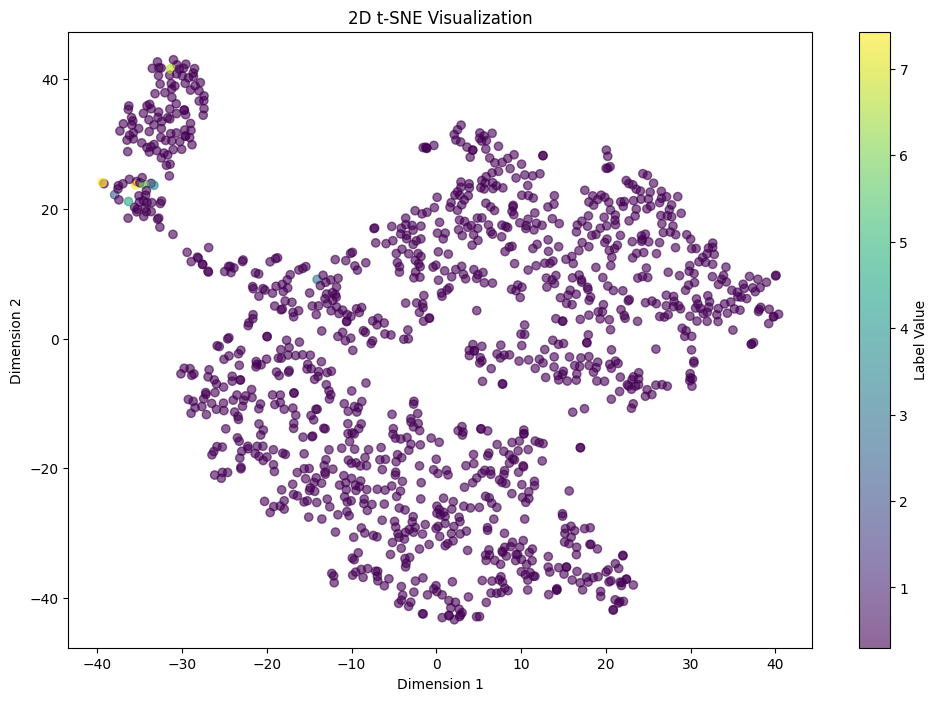

In [12]:
plot_tsne(feature_extractor, shuffled_train_x, shuffled_train_y)

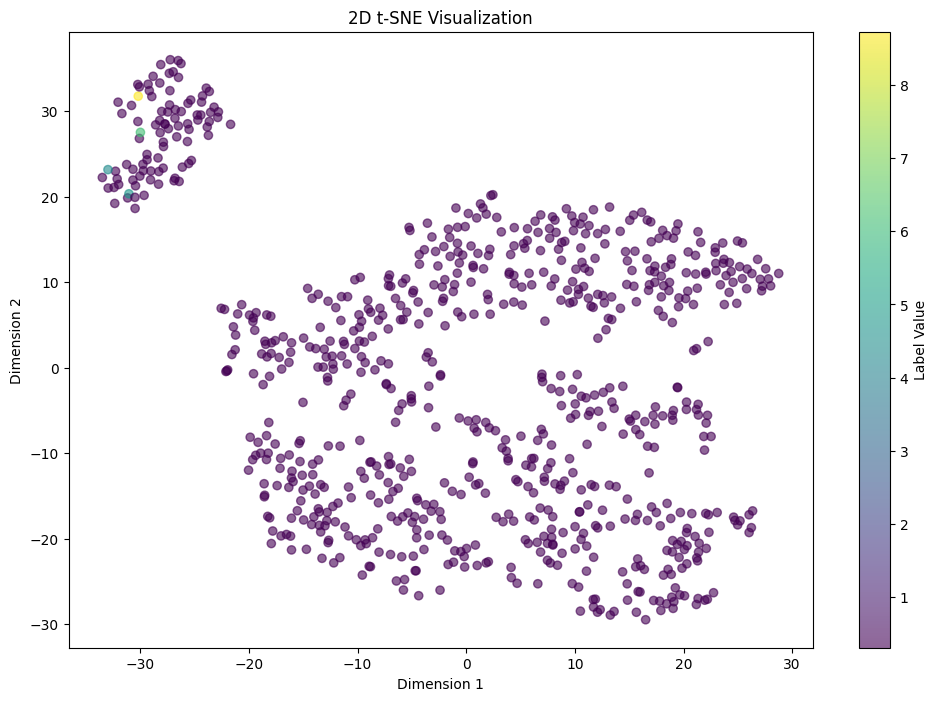

In [13]:
plot_tsne(feature_extractor, shuffled_test_x, shuffled_test_y)

In [15]:
import random


def find_optimized_random_batch_size(y, num_to_catch=3, threshold=np.log(10), num_trials=1000, early_exit_ratio=0.95):
    """
    Optimized function to find the minimum batch size such that, when sampled at random,
    each batch is likely to contain at least 2 rows with target values greater than a given threshold.
    
    Parameters:
    - y: Numpy array containing the target values
    - threshold: The target threshold, default is ln(10)
    - num_trials: Number of trials to perform for each batch size
    - early_exit_ratio: The success ratio to achieve before stopping the trials for a given batch size
    
    Returns:
    - Minimum batch size that fulfills the condition
    """
    # Count the number of elements greater than the threshold
    count_above_threshold = np.sum(y > threshold)

    # If there are fewer than 2 elements above the threshold, return a message
    if count_above_threshold < num_to_catch:
        raise ValueError("There are not enough samples with target values greater than the threshold.")

    # Loop through possible batch sizes, starting from 2
    for batch_size in range(num_to_catch, len(y) + 1):
        success_count = 0

        for trial in range(num_trials):
            # Sample a random batch
            random_batch = random.sample(list(y), batch_size)

            # Check if the batch contains at least 2 elements greater than the threshold
            if np.sum(np.array(random_batch) > threshold) >= num_to_catch:
                success_count += 1

            # Early exit if success ratio is achieved
            if trial >= 500 and success_count / (trial + 1) >= early_exit_ratio:
                return batch_size

# Find the minimum batch size for the training set that satisfies the condition, using the optimized function
# min_optimized_random_batch_size = find_optimized_random_batch_size(train_y, num_to_catch=3, num_trials=10000, early_exit_ratio=0.99)
# 
# min_optimized_random_batch_size


Run the command line:
 tensorboard --logdir logs/fit
Epoch 1/200
158/158 [==============================] - 9s 44ms/step - loss: 5.2884 - val_loss: 16.8052
Epoch 2/200
158/158 [==============================] - 6s 40ms/step - loss: 5.1317 - val_loss: 16.2020
Epoch 3/200
158/158 [==============================] - 6s 41ms/step - loss: 4.8469 - val_loss: 15.7904
Epoch 4/200
158/158 [==============================] - 7s 42ms/step - loss: 4.7112 - val_loss: 15.5498
Epoch 5/200
158/158 [==============================] - 6s 41ms/step - loss: 4.5831 - val_loss: 15.5319
Epoch 6/200
158/158 [==============================] - 7s 42ms/step - loss: 4.3751 - val_loss: 15.5773
Epoch 7/200
158/158 [==============================] - 7s 45ms/step - loss: 4.4951 - val_loss: 15.3167
Epoch 8/200
158/158 [==============================] - 6s 40ms/step - loss: 4.4511 - val_loss: 15.3579
Epoch 9/200
158/158 [==============================] - 7s 42ms/step - loss: 4.4456 - val_loss: 15.2816
Epoch 10/200
158/158

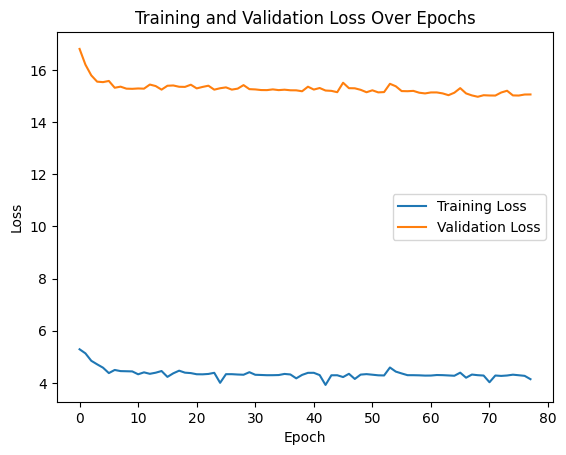

Epoch 1/69
198/198 [==============================] - 11s 47ms/step - loss: 6.5412
Epoch 2/69
198/198 [==============================] - 9s 45ms/step - loss: 6.4125
Epoch 3/69
198/198 [==============================] - 9s 46ms/step - loss: 6.4916
Epoch 4/69
198/198 [==============================] - 9s 47ms/step - loss: 6.1540
Epoch 5/69
198/198 [==============================] - 9s 46ms/step - loss: 6.5886
Epoch 6/69
198/198 [==============================] - 9s 46ms/step - loss: 6.4394
Epoch 7/69
198/198 [==============================] - 9s 46ms/step - loss: 6.4188
Epoch 8/69
198/198 [==============================] - 9s 45ms/step - loss: 6.4112
Epoch 9/69
198/198 [==============================] - 9s 45ms/step - loss: 6.4105
Epoch 10/69
198/198 [==============================] - 9s 46ms/step - loss: 6.2112
Epoch 11/69
198/198 [==============================] - 9s 45ms/step - loss: 6.3095
Epoch 12/69
198/198 [==============================] - 9s 45ms/step - loss: 6.4005
Epoch 13/69


In [13]:
mb.train_pds(feature_extractor, shuffled_train_x, shuffled_train_y, shuffled_val_x, shuffled_val_y, epochs=200,
             batch_size=8)

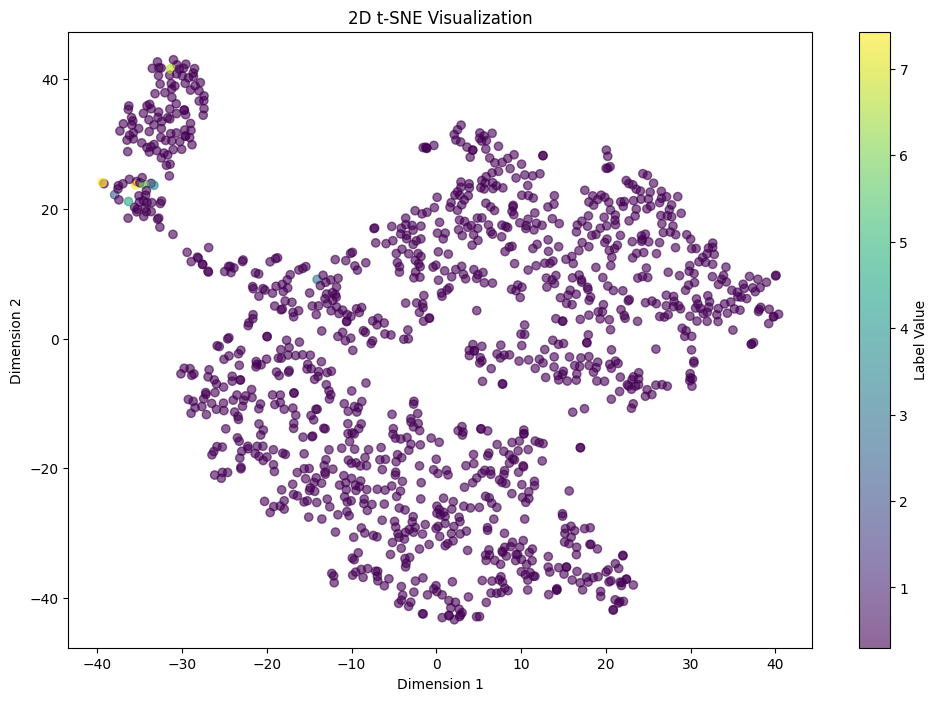

In [16]:
plot_tsne(feature_extractor, shuffled_train_x, shuffled_train_y)

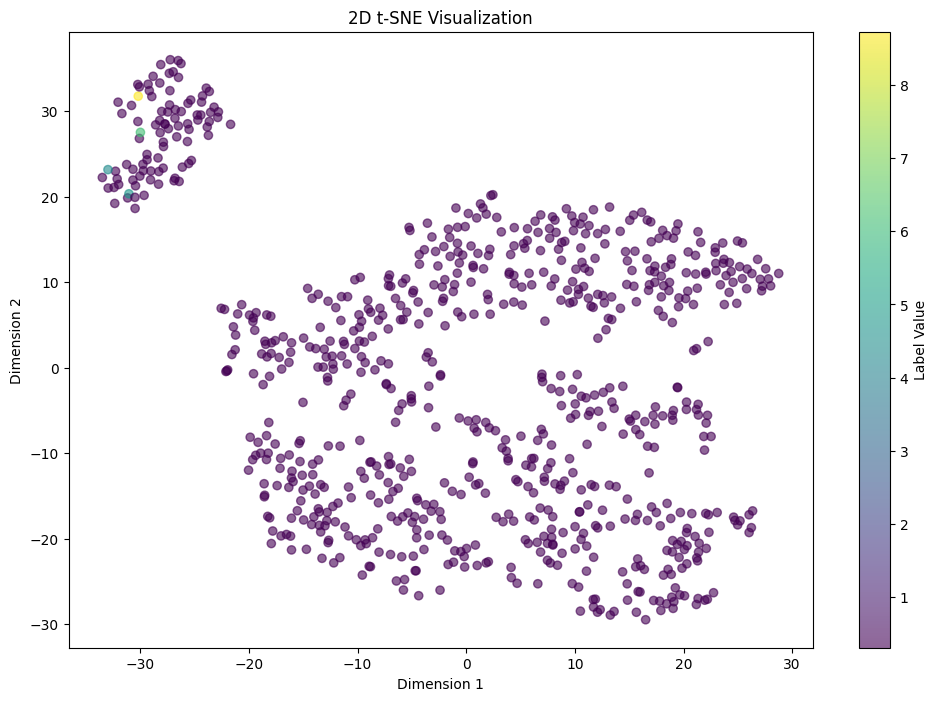

In [17]:
plot_tsne(feature_extractor, shuffled_test_x, shuffled_test_y)

# test 

In [25]:
res = next(mb.custom_data_generator(shuffled_train_x, shuffled_train_y, 8))  # works but always at the end
print(res)

(array([[0.24173065, 0.29508197, 0.24789644, 0.2068133 , 0.        ,
        0.196     , 0.6       , 0.73888889, 0.73333333, 0.57286432,
        0.3908046 , 0.37078652, 0.25081433, 0.74166667, 0.        ,
        0.99709256, 0.84019664, 0.        , 0.        ],
       [0.04381429, 0.05163934, 0.12330097, 0.10139485, 0.        ,
        0.1664    , 0.3625    , 0.81666667, 0.675     , 0.09045226,
        0.22988506, 0.35393258, 0.25880004, 0.64444444, 0.33333333,
        0.98229448, 0.21194244, 0.        , 0.        ],
       [0.66914914, 0.89754098, 0.66472492, 0.53299356, 0.        ,
        0.        , 0.3125    , 0.61944444, 0.79444444, 0.48241206,
        0.63218391, 0.63483146, 0.30019964, 1.        , 0.        ,
        0.99944864, 0.99938608, 0.88181017, 1.        ],
       [0.26104483, 0.50327869, 0.19352751, 0.11883047, 0.        ,
        0.4228    , 0.45      , 0.375     , 0.25      , 0.40703518,
        0.06896552, 0.51123596, 0.20994011, 0.25      , 0.        ,
        0.75

In [15]:
mb.train_pds_injection(feature_extractor, shuffled_train_x, shuffled_train_y, shuffled_val_x, shuffled_val_y,
                       epochs=200, batch_size=8)

Run the command line:
 tensorboard --logdir logs/fit
Epoch 1/200
 75/158 [=============>................] - ETA: 3s - loss: 216.5374

KeyboardInterrupt: 

In [18]:
from dataload import DenseReweights as DR

X_train:  [[0.17329155 0.22254098 0.18090615 0.15316524 0.5        0.4412
  0.375      0.51388889 0.45       0.89447236 0.27586207 0.3258427
  0.25007881 1.         0.16666667 0.98753009 0.41095356 0.56570345
  1.        ]
 [0.40370832 0.32377049 0.40226537 0.32939914 0.         0.
  0.425      0.53888889 0.45277778 0.35678392 0.6091954  0.41011236
  0.25711884 1.         0.         0.99827652 0.89677973 0.89882569
  1.        ]
 [0.224026   0.13934426 0.17055016 0.         0.         0.152
  0.6875     0.66666667 0.72777778 0.54773869 0.28735632 0.41011236
  0.21309236 0.73611111 0.33333333 0.99780308 0.34245777 0.
  0.        ]
 [0.30907764 0.20860656 0.31812298 0.26046137 0.         0.2268
  0.5625     0.775      0.87777778 0.27638191 0.2183908  0.73595506
  0.25470211 0.88888889 0.33333333 0.98268521 0.4012977  0.
  0.        ]
 [0.07168468 0.09836066 0.07734628 0.05472103 0.         0.
  0.4        0.23611111 0.2        0.68844221 0.31034483 0.65730337
  0.24955343 0.16666667 0.  

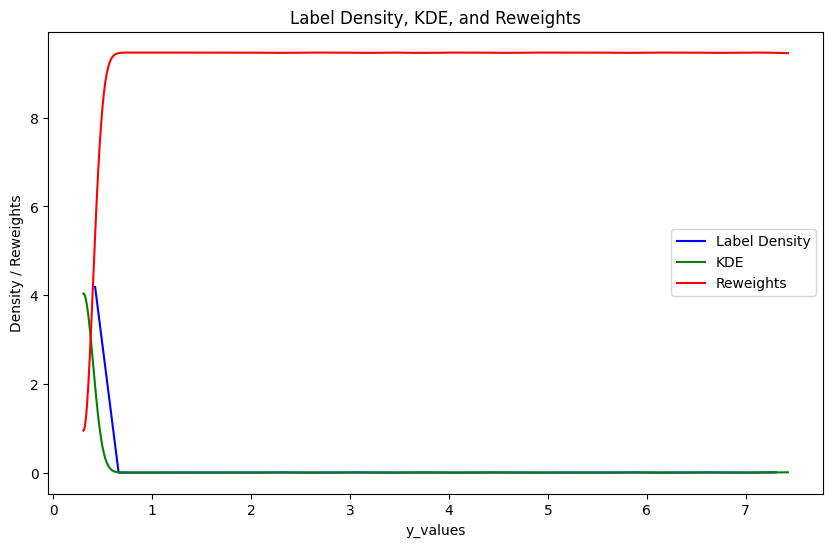

In [19]:
sample_weights = DR.DenseReweights(shuffled_train_x, shuffled_train_y, alpha=.9, debug=True)

X_train:  [[0.1813496  0.34385246 0.30873786 0.23175966 0.         0.2412
  0.225      0.67777778 0.71388889 0.40201005 0.42528736 0.57303371
  0.2818115  0.76388889 0.16666667 0.99920475 0.92007568 0.
  0.        ]
 [0.10491237 0.16393443 0.11003236 0.08959227 0.         0.14
  0.5875     0.32222222 0.175      0.68844221 0.13793103 0.78651685
  0.24913313 0.24166667 0.16666667 0.88620803 0.36584273 0.
  0.        ]
 [0.11885895 0.15040984 0.11877023 0.10300429 0.         0.
  0.4875     0.16944444 0.22222222 0.14572864 0.31034483 0.55617978
  0.24818745 0.15       0.         0.91192028 0.35339674 0.
  0.        ]
 [0.12961719 0.19672131 0.16957929 0.14270386 0.         0.148
  0.2375     0.37777778 0.18333333 0.19095477 0.1954023  0.58426966
  0.25795944 0.19166667 0.16666667 0.9450979  0.39258768 0.
  0.        ]
 [0.17049867 0.21516393 0.17087379 0.12097639 0.         0.15
  0.225      0.27222222 0.27777778 0.3718593  0.09195402 0.45505618
  0.2437743  0.26944444 0.16666667 0.623263

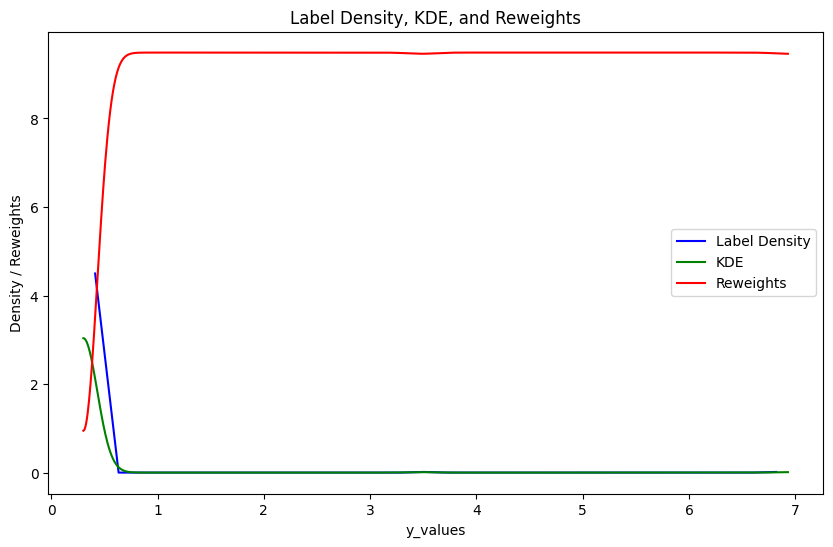

In [20]:
val_sample_weights = DR.DenseReweights(shuffled_val_x, shuffled_val_y, alpha=.9, debug=True)

Run the command line:
 tensorboard --logdir logs/fit
79/79 [==============================] - 2s 12ms/step - loss: 2.2542 - regression_head_loss: 2.2542 - val_loss: 2.2169 - val_regression_head_loss: 2.2169


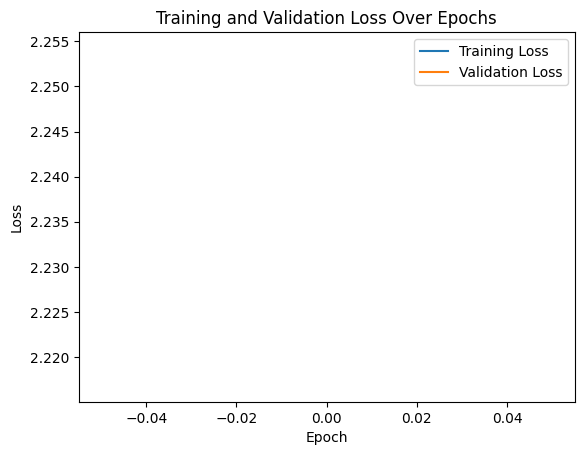

99/99 [==============================] - 1s 6ms/step - loss: 2.0705 - regression_head_loss: 2.0705


In [23]:
extended_model = mb.add_regression_head_with_proj(feature_extractor)
# fine-tuning
history = mb.train_reg_head(
    extended_model,
    shuffled_train_x,
    shuffled_train_y,
    shuffled_val_x,
    shuffled_val_y,
    sample_weights=sample_weights.reweights,
    sample_val_weights=val_sample_weights.reweights,
    learning_rate=1e-4,
    epochs=1, batch_size=16)

In [24]:
def plot_tsne_pds_extended_model(model, X, y, prefix='', save_tag=None):
    """
    Applies t-SNE to the features extracted by the given extended model and saves the plot in 2D with a timestamp.
    The color of the points is determined by their label values.

    Parameters:
    - model: Trained extended feature extractor model
    - X: Input data (NumPy array or compatible)
    - y: Target labels (NumPy array or compatible)
    - prefix: Prefix for the file name

    Returns:
    - Saves a 2D t-SNE plot to a file with a timestamp
    """
    # saving the threshold
    threshold = np.log(10)

    # Extract features using the trained extended model
    features, _ = model.predict(X)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(features)

    # Identify above and below threshold indices
    above_threshold_indices = np.where(y > threshold)[0]
    below_threshold_indices = np.where(y <= threshold)[0]

    # Create scatter plot for below-threshold points
    plt.figure(figsize=(12, 8))
    plt.scatter(tsne_result[below_threshold_indices, 0], tsne_result[below_threshold_indices, 1],
                c=y[below_threshold_indices], cmap='viridis', alpha=0.6, label='Below Threshold')

    # Overlay scatter plot for above-threshold points
    scatter = plt.scatter(tsne_result[above_threshold_indices, 0], tsne_result[above_threshold_indices, 1],
                          c=y[above_threshold_indices], cmap='viridis', alpha=1.0, edgecolors='r',
                          label='Above Threshold')

    # Add a color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Label Value')

    # Add legend to differentiate above-threshold points
    plt.legend()

    plt.title('2D t-SNE Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    # Save the plot
    file_path = f"{prefix}_tsne_plot_{str(save_tag)}.png"
    plt.savefig(file_path)
    plt.close()


In [26]:
plot_tsne_pds_extended_model(extended_model, shuffled_train_x, shuffled_train_y)

In [27]:
from evaluate import evaluation as eval

ev = eval.Evaluator()

In [28]:
ev.evaluate(extended_model, shuffled_train_x, shuffled_train_y, threshold=10)

Mean Absolute Error: 0.37659206986427307
Sample with y = 4.54312455501621 belongs to bin 9 and has an error of 4.666612750256707
Sample with y = 5.772126246634751 belongs to bin 11 and has an error of 5.863367129508286
Sample with y = 6.691624580035713 belongs to bin 13 and has an error of 6.713342255065944
Sample with y = 7.428036061518883 belongs to bin 15 and has an error of 7.41456997155497
Sample with y = 7.416318345093869 belongs to bin 15 and has an error of 7.522452655458592


0.37659207

In [29]:
ev.evaluate(extended_model, shuffled_test_x, shuffled_test_y, threshold=10)

Mean Absolute Error: 0.3791730999946594
Sample with y = 0.3025850929940457 belongs to bin 1 and has an error of 0.5205033399785275
Sample with y = 4.342011606135645 belongs to bin 9 and has an error of 4.395205436089316
Sample with y = 4.755054635525384 belongs to bin 9 and has an error of 4.851883953035512
Sample with y = 6.136300551153431 belongs to bin 12 and has an error of 6.23472216949583
Sample with y = 8.732078739083455 belongs to bin 17 and has an error of 8.854018733478235


0.3791731